# Compte rendu Du Projet SAE 15
### Par **HARTMANN** Matthias et **BIENVENU** Victor
Dans le cadre du Projet de SAE 15, nous avons dû produire un outil d'analyse de l'activité d'un serveur.
Vous retrouverez cet outil dans ce notebook python.
Dans un premier temps vous verrez l'ensembles des fonctions pythons qui ont été écrites pour cet outil et elles vous seront commentées.
Ensuite vous pourrez accédez à l'outil qui vous permettra de visualiser de plusieurs façons les activités suivantes :
- Le nombre et les ports ouverts sur le serveur
- La connectivité du serveur par rapport à un autre serveur.


## Partie 1 : Les fonctions pythons

### Importation des modules permettant l'exploitations des fichiers CSV et la génération de graphiques

In [1]:
import csv
import numpy as np
from typing import Dict, List
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime

import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown


### Fonctions qui permettent de gérer les dates et les timestamps (Utilisé par les deux métriques) 

In [2]:
def dateFormatter(epoch:int, _ = None) -> str :
    """!
    @brief Cette fonction permet de convertir un timestamp epoch en une date compréhensible.

    Paramètres : 
        @param epoch : int => timestamp dans le format epoch
        @param _ = None => Un paramètre qui est requis par matplotlib mais non utilisé par la fonction
    Retour de la fonction : 
        @return str => La date compréhensible

    """
    if epoch > 0:
        return str(datetime.fromtimestamp(epoch))
    return ""

def inverseDateFormatter(date: str) -> str:
    return int(parser.parse(date).timestamp())

def secondsToTime(s):
    hour = s // 3600
    s = s % 3600
    minute = s // 60
    s = s % 60
    return f'{hour}:{minute}:{s}'

def xlabels(tmps):
        l = []
        for i in list(tmps):
            if i not in l:
                l.append(dateFormatter(i))
            else:
                l.append("")
        return l


def ticks(tickList : list, axe="x"):
    if axe == "x":
        if len(tickList)> 4:

            x : list = [
                tickList[0],
                tickList[int(len(tickList) * 1/4)], 
                tickList[int(len(tickList) * 2/4)], 
                tickList[int(len(tickList) * 3/4)], 
                tickList[-1]
            ]
            plt.xticks(x, xlabels(x))
        else:
            plt.xticks(tickList, xlabels(tickList))

### Partie 1.1 : L'analyse des ports

#### Fonctions permettant de récuppérer le protocol associé à un numéro de port.

In [3]:
def _getDico():
    """!
    @brief Cette fonction permet de créer un dictionnaire à partir d'un tableau csv. Le tableau représente les numéros de ports correspondant à des protocols connus
    """
    with open('./python/portsList.csv', 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        dico:Dict[int, str] = {} # création du dictionnaire
        for row in csv_reader:
            try:
                dico[int(row[1])] = row[0] #Si la ligne du csv possède un port correct alors on le met dans le dictionnaire en tant que clé et son protocol en tant que valeur
            except:
                pass
    return dico  

_listport = _getDico() #On sauvegarde le dictionnaire pour ne pas le regénérer à chaque appel de fonction.
def converter(port:str) -> str or None:
    """!
    @brief Cette fonction permet de récuppérer un protocol à partir d'un numéro de port.

    Paramètres : 
        @param port : str => Le numéro de port dont on souhaite connaitre le protocol
    Retour de la fonction : 
        @return str or None => Le protocol associé au numéro de port ou None si aucun n'a été trouvé

    """
    try:
        return _listport.get(int(port), None)
    except:
        return None


#### Récuppération des donnés représentant l'activité des ports du serveur.

In [4]:
def recupperationDonnesPorts(chemin:str) -> Dict[str, Dict[int, Dict[str, str or None]]]:
    """!
    @brief Cette fonction permet de récupperer les données relatives à l'activité des ports et de les convertir en un Dictionnaire utilisable par les fonctions suivantes.

    Paramètres : 
        @param chemin : str => Le chemin menant au fichier csv où se trouve les données d'activité des ports.
    Retour de la fonction : 
        @return Dict[str, Dict[int, Dict[str, str]]] => Le dictionnaire représentant les données des ports. 

    """

    dico = {}
    with open(chemin, newline='') as csvfile:
        datareader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in datareader: # pour chaque ligne du fichier csv
            """
            Les données du csv sont organisées comme suit :
            @ip,port,protocol,timestamp
            """

            interface : str = row[0] #On recuppère l'adresse ip liée à l'interface
            temps : int = int(row[3]) #On récuppère le timestamp
            port : str = row[1] # On récuppère le port
            protocol : str or None = converter(row[2]) # Et on récuppère le protocol, celui-ci étant un numéro de port nous devons le convertir grace à la fonction converter(vue plus haut)
            
            """
            Nous suivons ensuite l'algorithme suivant:

            Si l'adresse ip se trouve déjà dans les clés du dictionnaire principal
                Si le timestamp se trouve déjà dans les clés du dictionnaire associé à l'interface
                    On ajoute un nouveau couple clé valeur (port, protocol) dans le dictionnaire associé au timestamp
                Sinon
                    On crée un nouveau dictionnaire ayant déjà un couple clé valeur (port, protocol) que l'on assigne comme étant le dictionnaire associé au timestamp
            Sinon
                On crée un nouveau dictionnaire ayant pour clé le timestamp et pour valeur un autre dictionnaire avec le couple (port, protocol) que l'on assigne à l'interface 
                courante dans le dictionnaire principal.
            """

            if interface in dico:
                if temps in dico[interface]:
                    dico[interface][temps][port] = protocol
                else:
                    dico[interface][temps] = {port:protocol}
            else:
                dico[interface] = {
                    temps:{port:protocol}
                }
                
    return dico # On renvoie le dictionnaire principal.

#### Fonction générant le premier graphique représentant le nombre de port ouvert sur le serveur (ou sur une interface particulière) en fonction du temps

In [5]:
def affichageNombrePort(portDict: Dict[str, Dict[int, Dict[str, str or None]]], interface="toutes", temps_debut:int=-1, temps_fin:int = float('inf')):
    """!
    @brief Cette fonction permet de générer un histogram représenant le nombre de port ouverts sur le serveur ou sur une interface en fonction d'une période 

    Paramètres : 
        @param portDict : Dict[str,np.ndarray] => Le dictionnaire représentant les données d'activité des ports
        @param interface = "toutes" => L'adresse ip de l'interface à observer, par défaut toutes les interfaces seront prises en compte.
        @param temps_debut : int = -1 => Le timestamp de début de période, par défaut tous les timestamps seront compris
        @param temps_fin : int = float('inf') => Le timestamp de fin de période, par défaut tous les timestamps seront compris

    """
    times = {} # On prépare un dictionnaire qui nous permettra d'avoir en clé les timestamps et en valeurs le nombre de ports qui était ouvert à cet instant.
    fig, axs = plt.subplots() #On prépare une fenêtre matplotlib


    """
    On suit l'algorithme suivant:

    Si l'interface entrée en paramètre n'existe pas dans les clés de portDict
        Pour chaque interface
            Pour chaque timestamp dans les clés de portDict[interface]
                Si le timestamp se trouve déjà dans les clés de times
                    On augmente le total se trouvant dans times[temps] par le nombre de ports se trouvant dans le dictionnaire associé au timestamp
                Sinon
                    On place le nombre de ports se trouvant dans le dictionnaire associé au timestamp dans times[temps]
    Sinon
        Pour chaque timestamp dans les clés de portDict[interface]
            Si le timestamp se trouve déjà dans les clés de times
                On augmente le total se trouvant dans times[temps] par le nombre de ports se trouvant dans le dictionnaire associé au timestamp
            Sinon
                On place le nombre de ports se trouvant dans le dictionnaire associé au timestamp dans times[temps]
    """
    

    if interface not in portDict:
        fig.suptitle("Nombre de port ouverts par rapport au temps (toutes interfaces)", fontsize=24)
        for inter in portDict:
            for temps in portDict[inter]:
                if temps_debut <= temps and temps <= temps_fin:
                    if temps in times:
                        times[temps] += len(portDict[inter][temps])
                    else:
                        times[temps] = len(portDict[inter][temps])
    else:
        fig.suptitle(f"Nombre de port ouverts par rapport au temps (Interface : {interface})", fontsize=24)
        for temps in portDict[interface]:
            if temps_debut < temps and temps < temps_fin:
                if temps in times :
                    times[temps] += len(portDict[interface][temps])
                else:
                    times[temps] = len(portDict[interface][temps])
    

    axs.bar(times.keys(),times.values(), width=4) # On crée un histogram ayant pour X les timestamps (times.keys()) et pour y les totaux (times.values)
    axs.xaxis.set_major_formatter(dateFormatter) # On demande à matplotlib d'utiliser la fonction dateFormatter pour afficher des dates compréhensible au lieu des timestamps normaux
    fig.autofmt_xdate() # On active la fonction de matplotlib permettant d'afficher en diagonale les dates pour faciliter la lecture 

#### Fonction générant le deuxième Graphique représentant l'état d'un numéro de port sur le serveur(ou bien sur une interface particulière) en fonction d'une période 

In [6]:
def affichageActivitePort(portDict: Dict[str, Dict[int, Dict[str, str or None]]], port: str, interface:str ="toutes", temps_debut:int=-1, temps_fin:int = float('inf')):
    """!
    @brief Cette fonction permet d'afficher un graphique montrant l'état d'un port

    Paramètres : 
        @param portDict : Dict[str,Dict[int,Dict[str,strorNone]]] => Le dictionnaire représentant les données d'activité des ports
        @param port : str => le numéro du port à observer
        @param interface : str = "toutes" => l'adresse ip de l'interface sur laquelle observer le port, par défaut toutes les interfaces seront affichées.
        @param temps_debut : int = -1 => Le timestamp de début de période, par défaut tous les timestamps seront compris
        @param temps_fin : int = float('inf') => Le timestamp de fin de période, par défaut tous les timestamps seront compris

    """
    
    fig, axs = plt.subplots() #On prépare une fenêtre matplotlib
    inters : list = list(portDict.keys()) #On récuppère la liste des adresses ip des interfaces.
    if temps_debut == temps_fin:
        temps_fin += 24*3600

    """
    On suit l'algorithme suivant:

    Si l'interface entrée en paramètre n'existe pas dans les clés de portDict
        On crée une liste tmps qui contiendra les timestamps et une liste interfaces qui contiendra les id des interfaces pour chaque timestamp
        Pour chaque interface dans portDict
            Pour chaque timestamp dans portDict[interface]
                Si le numéro de port se trouve dans le dictionnaire portDict[interface][timestamp]
                    On ajoute le timestamp dans tmps
                    On ajoute l'identifiant de l'interface dans interfaces
        On génère un nuage de points. à partir des timestamps en X et des id d'interfaces en y (tmps, interfaces)
    Sinon
        On change la liste inters pour qu'elle ne contienne que l'adresse ip de l'interface sélectionnée
        On créer une liste times qui contiendra les timestamps qui correspondent au port ouvert
        Pour chaque timestamp dans portDict[interface]
                Si le numéro de port se trouve dans le dictionnaire portDict[interface][timestamp]
                    On ajoute le timestamp dans tmps
        On génère un nuage de points. à partir des timestamps en X et en Y on génère une liste de 0 de la même taille que times
    """
    

    if interface not in portDict:
        fig.suptitle(f"Affichage de l'état du port {port} pour chaque interface", fontsize=24)
        tmps = []
        interfaces = []
        for inter in portDict:
            for temps in portDict[inter]:
                if temps_debut <= temps and temps <= temps_fin:
                    if port in portDict[inter][temps]:
                        tmps.append(temps)
                        interfaces.append(inters.index(inter))
        axs.scatter(tmps, interfaces)
        
        ticks(tmps)
        plt.yticks(interfaces, [inters[i] for i in interfaces])


    else:
        fig.suptitle(f"Affichage de l'état du port {port} sur l'interface {interface}", fontsize=24)
        inters = [interface]
        times = []
        for temps in portDict[interface]:
            if temps_debut <= temps and temps <= temps_fin:
                if port in portDict[interface][temps]:
                    times.append(temps)
        axs.scatter(times, [0 for _ in times])

        ticks(times)
        plt.yticks([0 for _ in times],[interface for _ in times])

    
    def interFormatter(id,_)->str:
        """!
        @brief Cette fonction permet de formater l'affichage en y du graph. Celui-ci affichera les adresses ip des interfaces au lieu des nombres normaux.

        Paramètres : 
            @param id => un nombre qui correspond à l'index de l'adresse ip dans la liste inters 
            @param _ => Un paramètre qui est requis par matplotlib mais non utilisé par la fonction
        Retour de la fonction : 
            @return str => Une adresse ip correspondant à une interface ou une chaine vide

        """
        if id in [float(i) for i in range(len(inters))]:
            return inters[int(id)]
        else:
            return ""
    

    

    axs.yaxis.set_major_formatter(interFormatter) # On demande à matplotlib d'utiliser la fonction interFormatter pour afficher des adresses ip d'interface au lieu des nombres par défaut
    fig.autofmt_xdate() # On active la fonction de matplotlib permettant d'afficher en diagonale les dates pour faciliter la lecture 


### Partie 1.2 : L'analyse de la connectivité

#### Récuppération des données représentant la connectivité du serveur 

In [7]:
def recupperationDonnesConnectivite(chemin: str)-> Dict[int,np.ndarray]:
    """!
    @brief la fonction permet de récupérer 2 fichier csv puis de les mettre sous forme d'un Dict[str, np.ndarray]

    Paramètres : 
        @param chemin : str => chemin du fichier csv de la metrique 1
    Retour de la fonction : 
        @return Dict[int,np.ndarray] => Dictionnaire représentant les données de connectivité

    """
    
    connectDict: Dict[int,List[int]] = {} # Dictionnaire qui représentera les données de connectivité
    up : int #débit montant en Kilo octet par seconde
    down : int # débit descendant en Kilo octet par seconde
    tps : int # Le timestamp
    pg : int # durée du ping en milisecondes
    
    # On ouvre le fichier csv contenant les données et on le lit
    # Il est organisé comme suit : ping, download, upload, timestamp
    with open(chemin, newline='') as csvfile:
        datareader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in datareader:
            
            up = int(row[0])
            down = int(row[1])
            pg = int(row[2])
            tps = int(row[3])
            # On ajoute dans le dictionnaire le couple suivant
            # clé = timestamp, valeur = List[upload, download, ping]
            connectDict[tps] = [up, down, pg]  
        
    return connectDict # on retourne le dictionnaire

#### Fonctions générant le premier graphique représentant les statistiques de connectivité sur une période

In [8]:
def affichageStatistiqueConnectivite(connectdict: Dict[str,List[int]], mode="tous", temps_debut:int=-1, temps_fin:int = float('inf')):
    """!
    @brief Cette fonction permet d'afficher un graphique montrant données de connectivité en fonction du temps

    Paramètres : 
        @param connectdict : Dict[str,List[int]] => dictionnaire représentant les données de connectivité
        @param mode = "tous" => Chaine de caractère qui permet de choisir quelles données afficher. (toutes, ping, upload, download)
        @param temps_debut : int = -1 => Le timestamp de début de période, par défaut tous les timestamps seront compris
        @param temps_fin : int = float('inf') => Le timestamp de fin de période, par défaut tous les timestamps seront compris

    """
    
    def graphique(connectdict: Dict[str,List[int]],axs : plt.Axes, x: List[int], y: List[int], titre: str):
        axs.scatter(x,y)
        axs.plot(x,y,'r:')
        axs.set_title(titre)
        axs.xaxis.set_major_formatter(dateFormatter) # On demande à matplotlib d'utiliser la fonction dateFormatter pour afficher des dates compréhensible au lieu des timestamps normaux

    y : List[int] = []
    x : List[int] = []
    titres = ["Upload en Ko/s en fonction du temps","Download en Ko/s en fonction du temps","Ping en ms en fonction du temps"]
    if mode != "tous":
        modes = ["upload","download","ping"]
        mode_id = modes.index(mode)
        for i in connectdict:
            if temps_debut <= i and i <= temps_fin:
                y.append(connectdict[i][mode_id])
                x.append(i)
        
        fig, axs = plt.subplots()   
        graphique(connectdict, axs, x, y, titres[mode_id])
    else:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
        
        i : int = 0
        for ax in axes:
            y.clear()
            x.clear()
            for tmp in connectdict:
                if temps_debut <= tmp and tmp <= temps_fin:
                    y.append(connectdict[tmp][i])
                    x.append(tmp)
            graphique(connectdict, ax, x, y, titres[i])
            i += 1
    fig.autofmt_xdate() # On active la fonction de matplotlib permettant d'afficher en diagonale les dates pour faciliter la lecture 
    

### deuxieme graphique

In [17]:
def affichageHistogrameMoyennes(connectdict: Dict[str,List[int]], temps_debut:int=-1, temps_fin:int = float('inf')):
    
    fig = plt.subplot(1,2,1)
    
    titres : List[str] = ["Upload","Download","Ping"]
    y : Dict[int, int] = {0:0, 1:0, 2:0}
    compteur : Dict[int, int] = {0:0, 1:0, 2:0}
    
    for tmp in connectdict:
        if temps_debut <= tmp and tmp <= temps_fin:
            for i in range(3):
                y[i] += connectdict[tmp][i]
                compteur[i] += 1

    fig.bar(
        range(len(titres)-1), 
        [y[i]/compteur[i] for i in range(2)]
    )
    fig.yaxis.grid(True)
    plt.xticks(range(len(titres)-1), titres[:2])
    plt.ylabel("kilo octet/s")
    
    fig.set_title("Upload / Download")
    
    fig = plt.subplot(1,2,2)
    
    fig.bar(0, y[2]/compteur[2])
    fig.yaxis.grid(True)
    plt.xticks([0], ["Ping"])
    plt.ylabel("millisecondes")
    fig.set_title("Moyenne des pings")
    plt.subplots_adjust(wspace=0.4, top=.8)
    
    p_deb = dateFormatter(list(connectDict.keys())[0])
    p_fin = dateFormatter(list(connectDict.keys())[-1])
    if temps_debut != -1 :
        p_deb = dateFormatter(temps_debut)
    if temps_fin != float('inf'):
        p_fin = dateFormatter(temps_fin)
    
    plt.suptitle(f"Moyennes des différentes mesures\n Sur la période {p_deb} -> {p_fin}", fontsize=18)
    

## Partie 2 : L'outil de supervision

### Importations des données depuis les fichiers csv

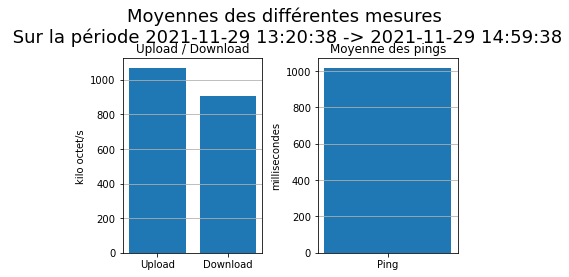

In [18]:
chemin_port : str = "./python/portData.csv"
chemin_connect : str = "./python/connectivityData.csv"
portDict: Dict[str, Dict[int, Dict[str, str or None]]] = recupperationDonnesPorts(chemin_port)
connectDict : Dict[int, List[int]] = recupperationDonnesConnectivite(chemin_connect)

In [11]:
timeList = [secondsToTime(i) for i in range(24*3600)]

def notebookNombrePort()-> widgets.widget_box.Box:
    interfaces = list(portDict.keys())
    interfaces.insert(0, "Toutes")
    dropdown = widgets.Dropdown(
        options=interfaces,
        value=interfaces[0],
        description='Interface(s):',
    )
    deb = widgets.DatePicker(
    )
    deb_label = widgets.Label(
        'Choisissez une date de début de période'
    )
    deb_picker = widgets.SelectionSlider(
        options=timeList,
        index=0,
        value=timeList[0]
    )
    fin = widgets.DatePicker(
    )
    fin_label = widgets.Label(
        'Choisissez une date de fin de période'
    )
    fin_picker = widgets.SelectionSlider(
        options=timeList,
        index=len(timeList)-1,
        value=timeList[len(timeList)-1]
    )
    Hbox = widgets.HBox([
        widgets.VBox([deb_label,deb, deb_picker]),
        widgets.VBox([fin_label,fin, fin_picker]),
    ]) 


    button_nombrePort = widgets.Button(
        description="Afficher l'histogram",
        button_style='info',
        icon='check'
    )
    output = widgets.Output()

    def func_button_nombrePort(_):
        with output:
            clear_output()
            if deb.value != None and fin.value != None:
                print(deb_picker.value)
                affichageNombrePort(portDict, dropdown.value, inverseDateFormatter(f'{deb.value} {deb_picker.value}'), inverseDateFormatter(f'{fin.value} {fin_picker.value}'))
            else:
                affichageNombrePort(portDict, dropdown.value)
            plt.show()

    button_nombrePort.on_click(func_button_nombrePort)


    
    Vbox = widgets.VBox([dropdown,Hbox, button_nombrePort, output])
    app_layout = widgets.Layout(display='flex',
                    flex_flow='row nowrap',
                    align_items='center',
                    border='none',
                    width='100%',
                    margin='5px 5px 5px 5px')

    app = widgets.Box([Vbox], layout=app_layout)
    return app

def notebookActivitePort() -> widgets.widget_box.Box:
    interfaces = list(portDict.keys())
    interfaces.insert(0, "Toutes")
    dropdown = widgets.Dropdown(
        options=interfaces,
        value=interfaces[0],
        description='Interface(s):',
    )

    port = widgets.BoundedIntText(
        value=22,
        min=0,
        max=65535,
        step=1,
        description='n°port:',
    )

    Hbox1 = widgets.HBox([dropdown, port])

    deb = widgets.DatePicker(
    )
    deb_label = widgets.Label(
        'Choisissez une date de début de période'
    )
    deb_picker = widgets.SelectionSlider(
        options=timeList,
        index=0,
        value = timeList[0]
    )
    fin = widgets.DatePicker(
    )
    fin_label = widgets.Label(
        'Choisissez une date de fin de période'
    )
    fin_picker = widgets.SelectionSlider(
        options=timeList,
        index=len(timeList)-1,
        value = timeList[len(timeList)-1]
    )
    Hbox2 = widgets.HBox([
        widgets.VBox([deb_label,deb, deb_picker]),
        widgets.VBox([fin_label,fin, fin_picker]),
    ])

    button_etatPort = widgets.Button(
        description="Afficher l'état du port'",
        button_style='info',
        icon='check'
    )
    output = widgets.Output()

    def func_button_etatPort(_):
        with output:
            clear_output()
            if deb.value != None and fin.value != None:
                affichageActivitePort(portDict, str(port.value), dropdown.value, inverseDateFormatter(f'{deb.value} {deb_picker.value}'), inverseDateFormatter(f'{fin.value} {fin_picker.value}'))
            else:
                affichageActivitePort(portDict, str(port.value), dropdown.value)
            plt.show()

    button_etatPort.on_click(func_button_etatPort)

    Vbox = widgets.VBox([Hbox1,Hbox2, button_etatPort, output])
    app_layout = widgets.Layout(display='flex',
                    flex_flow='row nowrap',
                    align_items='center',
                    border='none',
                    width='100%',
                    margin='5px 5px 5px 5px')

    app = widgets.Box([Vbox], layout=app_layout)
    return app




actualisation_port_button = widgets.Button(
    description='Actualiser',
    button_style="success"
)

def actualiser_port(_):
    global portDict
    portDict = recupperationDonnesPorts(chemin_port)

actualisation_port_button.on_click(actualiser_port)

actualisation_port_button

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


## Supervision du nombre de port ouverts sur le serveur

In [12]:
display(notebookNombrePort())

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


## Supervision de l'état d'un port sur le serveur

In [13]:
display(notebookActivitePort())

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.
